In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field # 데이터를 어떻게 처리할지 조절
from torchtext.data import BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [2]:
# 시드 설정
seed = 55

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### DATA 불러오기

In [3]:
import de_core_news_sm
import en_core_web_sm

In [4]:
spacy_en = en_core_web_sm.load()
spacy_de = de_core_news_sm.load()

In [5]:
def tokenize_de(text): # 역순으로 가져오는게 더 좋은 학습을 했다는 연구가 있음
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


#
SRC = Field(tokenize = tokenize_de, 
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True)

TRG = Field(tokenize = tokenize_en,
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

In [7]:
# 예시 확인
print(train_data.examples[0].src)
print(train_data.examples[0].trg)

['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [8]:
# min_freq = 2 : 2번 이상 등장한 토큰을 출력
# 토큰이 1번 등장 시, <unk> 로 대체
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' # cuda가 왜 안 되지..

# print(device) # cuda 확인용 \
batch_size = 128
train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size = batch_size, device = device
)

### Seq2Seq 구현

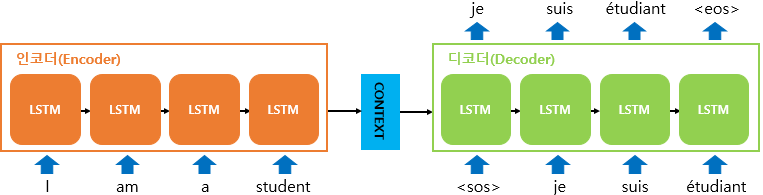

In [81]:
# Encoder 구현
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout): 
        
        # input_size : input 데이터의 vocab_size
        # emb_size : 임베딩 사이즈
        # hidden_size : 히든 스테이트 차원(=cell state 차원)
        # n_layers : RNN 레이어 개수
        # dropout : 과적합 방지용
        # n_directions =1 // 이때, bidirectional RNN 의 경우는 n_directions = 2 
        
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.emb_size = emb_size
        self.dropout = dropout
        
        # 임베딩
        self.embedding = nn.Embedding(input_size, emb_size)
        
        # encoder 구성을 보통 LSTM, GRU, RNN 층으로 구성하는 편?
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
         
    def forward(self, src):
        # x : [src_len, batch_size]

        # 임베딩 - 드롭아웃 - lstm 
        x = self.embedding(src)
        x - self.dropout(x)
        enc_out, (hidden, cell) = self.lstm(x)
        
        # enc_out : [src_len, batch_size, hidden_size * n directions]
        # hidden, cell : [n_layers * n_directions , batch_size, hidden_size]
        
        return hidden, cell
    
# Decoder 구현
class Decoder(nn.Module):
    # encoder 이후 마지막 hidden_state가 context vector로 들어감
    def __init__(self, output_size, emb_size, hidden_size, n_layers, dropout): # input size 와 output size 가 같을 필요가 없음
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size) #fc layer 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp, hidden, cell):
        # inp : [batch_size]
        # hidden, cell : [n_layers * n_directions, batch_size, hidden_size]
        inp = inp.unsqueeze(0) # inp -> [1, batch_size]
        
        x = self.embedding(inp)
        x = self.dropout(x)
        
        dec_out, (hidden, cell) = self.lstm(x, (hidden,cell)) # 두 인자의 의미..?
        # dec_out : [seq_len, batch_size, hidden_size * n_directions]
        # hidden, cell : [n_layers * n_directions, batch_size, hidden_size]
        
        
        pred = self.linear(dec_out.squeeze(0))
        return pred, hidden, cell

In [82]:
# Seq2Seq 구현
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        # src = [src len, batch_Size]
        # trg = [trg len, bastch_size]
        
        trg_len = trg.shape[0] # 타켓 토큰 길이
        batch_size - trg.shape[1] 
        trg_vocab_size = self.decoder.output_size
        
        # decoder 결과를 저장할 텐서
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        
        # encoder 마지막 hidden state : context vector
        hidden, cell = self.encoder(src)
        
        # Decoder에 들어갈 첫 input 은 <sos>
        inp = trg[0, :]
        
        for t in range(1, trg_len):  # <eos> 제외하고 trg_len-1 만큼 반복
            output, hidden, cell = self.decoder(inp,  hidden, cell)
            outputs[t] = output 
            
            teacher_force = random.random() < teacher_forcing_ratio 
            top1 = output.argmax(1)
            
            
            # 일정 확률로 다음 LSTM 블록에 이전 예측 결과 값이 아니라 target(정답)을 입력
            inp = trg[t] if teacher_force else top1
        
        return outputs

In [83]:
len(SRC.vocab.itos) # itos : integer to string? 반대로 stoi : string to integer

7853

## 학습


### 하이퍼파라미터
- input_size : input 데이터의 vocab_size
- emb_size : 임베딩 사이즈
- hidden_size : 히든 스테이트 차원(=cell state 차원)
- n_layers : RNN 레이어 개수
- dropout : 과적합 방지용
- n_directions =1 // 이때, bidirectional RNN 의 경우는 n_directions = 2 


In [84]:
# 하이퍼 파라미터 설정
inp_dim = len(SRC.vocab)
out_dim = len(TRG.vocab)

enc_emb_dim = 256 #임베딩 차원
dec_emb_dim = 256

hid_dim = 512 # hidden state 차원
n_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

In [85]:
# 모델 생성
enc = Encoder(input_size=inp_dim, emb_size=enc_emb_dim, hidden_size= hid_dim, n_layers=n_layers, dropout=enc_dropout)
dec = Decoder(output_size=out_dim, emb_size=dec_emb_dim, hidden_size= hid_dim, n_layers=n_layers, dropout=dec_dropout)
model = Seq2Seq(enc,dec).to(device)

In [86]:
# 가중치 초기화
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (linear): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [87]:
# 모델 학습 가능한 파라미터 수 측정
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainableparameters')

The model has 13,898,501 trainableparameters


In [88]:
# optimizer
optimizer = optim.Adam(model.parameters())

# loss function
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token] # string to integer
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx) # pad 에 해당하는 index는 무시하도록

In [89]:
def train(model, iterator, optimizer, criterion, clip):
    print('train mode')
    model.train()
    epoch_loss = 0
    
    for i , batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        
        output = model(src, trg) # [trg len, batch size, output dim]
        output_size = output.shape[-1]
        
        #print(f'output shape : {output.shape}')
        output = output[1:].view(-1, output_size)
        #print(f'output shape : {output.shape}')
        #print(f'trg shape : {trg.shape}')
        trg = trg[1:].view(-1)
        #print(f'trg shape : {trg.shape}')
        
        loss = criterion(output, trg)
        loss.backward()
        
        # 기울기 clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [90]:
def evaluate(model, iterator, criterion):
    print('eval mode')
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            
            # [trg_len, batch_size, output_size]
            output = model(src, trg, teacher_forcing_ratio = 0) # teacher forcing을 없애주기 위함
            output_size = output.shape[-1]
            #rint(f'output shape : {output.shape}')
            output = output[1:].view(-1, output_size) # [(trg_len-1)*batch_size, output_size]
            #rint(f'output shape : {output.shape}')
            
            #rint(f'trg shape : {trg.shape}')
            trg = trg[1:].view(-1)
            #print(f'trg shape : {trg.shape}')
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
        return epoch_loss / len(iterator)

In [91]:
from tqdm import tqdm

In [ ]:
%%time
num_epochs = 1
clip = 1

best_valid_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    
#     start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iter, criterion)
    
#     end_time = time.time()
    
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'tut1-model.pt')
    
#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

  0%|          | 0/1 [00:00<?, ?it/s]

train mode


In [ ]:
### 